In [ ]:
from nbdev import *
%nbdev_default_export cell_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.cell_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Manage cell data
> Create cells from source data

In [ ]:
%nbdev_export
import os
import numpy as np
import pandas as pd
from wtlike.config import *
from wtlike.source_data import *
from wtlike.loglike import LogLike

In [ ]:
%nbdev_export
class CellData(SourceData):
    """Manage a set of cells generated from a data set
    
        Invoke superclass to load photon data and exposure for the source.
        Manage a list of cells
        
        * config Config instance, with file paths appropriate fo SourceData
        * source PointSource instance
        * exp_min minimum relative exposure -- applied to dataframe output
        * bins time bins: use default otherwise
        """
    
    def __init__(self, config, source, exp_min=0.3, bins=None, clear=False):
        """

        """
        super().__init__(config, source, clear )

        self.source_name =source.name
        self.verbose = config.verbose
        self.use_uint8  = config.use_uint8
        self.exp_min = exp_min
        photon_data = self.p_df
        
        # exposure binned as well
        self.fexposure, bins = self.binned_exposure( time_bins=bins, ) #bins, exposure)

        # manage bins 
        self.N = len(bins)-1 # number of bins
        self.bins = bins
        self.bin_centers = 0.5*(bins[1:]+bins[:-1])
        
        # restrict photons to range of bin times
        photons = photon_data.query(f'{bins[0]}<time<{bins[-1]}')

        # get the photon data with good weights, not NaN
        w = photons.weight
        good = np.logical_not(np.isnan(w))
        self.photons = photons.loc[good]
        self.weights = w = self.photons.weight.values
        
        # estimates for averate signal and background per cell
        self.S = np.sum(w)/self.N
        self.B = np.sum(1-w)/self.N

        # use photon times to get indices of bin edges
        self._edges = np.searchsorted(self.photons.time, bins)

    def __repr__(self):
        return f'''{self.__class__}:
        {len(self.fexposure)} intervals from {self.bins[0]:.1f} to {self.bins[-1]:.1f} for source {self.source_name}
        S {self.S:.2f}  B {self.B:.2f} '''

    def __getitem__(self, i):
        """ get info for ith time bin and return dict with
            t : MJD
            tw: bin width,
            e: exposure as fraction of total,
            n : number of photons in bin
            w : list of weights as uint8 integers<=255
            S,B:  value
        """
        k   = self._edges
        w = self.weights[k[i]:k[i+1]]
        wts = np.array(w*256, np.uint8) if self.use_uint8 else w
        n = len(wts)
        e = self.fexposure[i]
        tw  = self.bins[i+1]-self.bins[i]

        return dict(
                t=self.bin_centers[i], # time
                tw = tw,  # bin width
                e=e, # moving to this name
                n=n, # number of photons in bin
                w=wts,
                S= e *self.S,
                B= e *self.B,
                )

    def __len__(self):
        return self.N
    
    @property
    def dataframe(self):
        """ combine all cells into a dataframe, applying exposure cut
        """
        if hasattr(self, 'df'): return self.df
        emin = self.exp_min
        if emin is None: emin=0
        self.df = pd.DataFrame([cell for cell in self if cell['e']>emin ])
        return self.df
    
    def concatenate( self ):
        """
        Combine this set of cells to one
        Return a dict with summed n, S, B, and concatenated w
        """
        newcell = dict()
        cells = self.dataframe
        if 't' in cells:
            ca, cb =cells.iloc[0], cells.iloc[-1]
            newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

        for col in ' n S B'.split():
            newcell[col] = cells[col].sum()
        newcell['w'] = np.concatenate(list(cells.w.values))
        return newcell
    
        
    def all_data_likelihood(self ):
        """Concatentate all the cells, return a LogLike object"""
        return LogLike(self.concatenate()) 
    
    def plot_concatenated(self, fignum=1, **kwargs):
        """Likelihood function, with fit for concatenated data"""
        import matplotlib.pyplot as plt
        lka = self.all_data_likelihood()
        fig,ax = plt.subplots(figsize=(4,2), num=fignum)
        lka.plot(ax=ax, **kwargs) 
        return fig

In [ ]:
%nbdev_hide
show_doc(CellData)

<h2 id="CellData" class="doc_header"><code>class</code> <code>CellData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CellData</code>(**`config`**, **`source`**, **`exp_min`**=*`0.3`*, **`bins`**=*`None`*, **`clear`**=*`False`*) :: [`SourceData`](wtlike/source_data#SourceData)

Manage a set of cells generated from a data set

Invoke superclass to load photon data and exposure for the source.
Manage a list of cells

* config Config instance, with file paths appropriate fo SourceData
* source PointSource instance
* exp_min minimum relative exposure -- applied to dataframe output
* bins time bins: use default otherwise

photons and exposure for Geminga: Restoring from cache with key "Geminga_monthly_data"
CellData: Source Geminga with:
	 data:     2,355,559 photons from   2008-08-04 to 2021-04-02
	 exposure: 3,077,175 intervals from 2008-08-04 to 2021-04-02
Time bins: 4624 intervals of 1 days, from MJD 54683.0(2008-08-05) to 59307.0(2021-04-03))


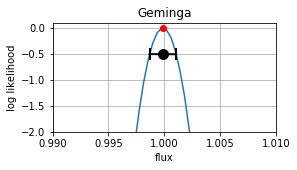

In [ ]:
%nbdev_hide
config = Config(data_folder='/home/burnett/monthly')
source = PointSource('Geminga')
cd = CellData(config, source)
cd.plot_concatenated(xlim=(0.99, 1.01), title=f'{source.name}');

In [ ]:
%nbdev_export
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [ ]:
%nbdev_export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edges delimiting boundaries between cells
    """
    # should check limitsk
    ii = np.searchsorted(cells.t, edges)
    
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

        ca, cb = subset.iloc[0], subset.iloc[-1]
        newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )

        for col in 'tw e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)      

In [ ]:
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
- cells -- A DataFrame of cells
- edges  -- a list of edges delimiting boundaries between cells

In [ ]:
%nbdev_hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_effective_area.ipynb.
Converted 02_data_man.ipynb.
Converted 03_source_data.ipynb.
Converted 04_photon_data.ipynb.
Converted 05_weights.ipynb.
Converted 06_poisson.ipynb.
Converted 07_cell_data.ipynb.
Converted 08_loglike.ipynb.
Converted 09_lightcurve.ipynb.
Converted 10_simulation.ipynb.
Converted 14_bayesian.ipynb.
Converted index.ipynb.
Wed Apr 28 03:59:55 PDT 2021
